In [55]:
from os.path import isfile
from tqdm import tqdm
from io import StringIO
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import cv2
import os
import json
%matplotlib inline


df = pd.read_csv("driving_log.csv", header=None)
#store features and labels in arrays. Angles is output
Cimages = df[[0]]
Cimages = Cimages.values
Limages = df[[1]]
Limages = Limages.values
Rimages = df[[2]]
Rimages = Rimages.values

#Store Output Data and Concatenate
Y = df[3]
Y = Y.values
#Apply angle correction and load left and right camera steering angles
YL = df[3] + 0.27
YL = YL.values
YR = df[3] - 0.27
YR = YR.values
# Store camera angles in single array.
Y = np.concatenate((Y,YL))
Y = np.concatenate((Y,YR))
print("Outputs Loaded")





Outputs Loaded


In [56]:
#load Center Images into array
def loadandresize(images):
    conversion= []
    for n in range(len(images)):
        temp = str(images[n].item()).strip()
        #temp =  "IMG/" +temp[47:]
        #read in the image
        img = cv2.imread(temp, 1)
        height, width = img.shape[:2]
        res = cv2.resize(img, (0,0), fx=0.625, fy=0.625) 
        crop_img = res[39:85, 0:200] # Crop sky and hood
        img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB) # Switch BGR to RGB
        conversion.append(img)
    return conversion
X_train = np.array(loadandresize(Cimages))
print("Center images loaded")

Center images loaded


In [57]:
X_train_left = np.array(loadandresize(Limages))
print("Left Images Loaded")

Left Images Loaded


In [58]:
X_train_right = np.array(loadandresize(Rimages))
print("Right Images Loaded")




Right Images Loaded


46 200 3
24108 24108


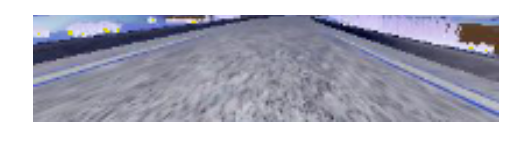

complete


In [59]:
#Stack  images into single array for processing
X_train = np.vstack((X_train,X_train_left))
X_train = np.vstack((X_train,X_train_right))
#Change int to float for normalization
X_train = X_train.astype('float32')


assert np.array_equal(len(X_train), len(Y)), 'length is not the same for training and labels'
height, width, channels = X_train[0].shape
#print height, width, # of channels
print(height, width, channels)
# print the number of samples
print(len(Y), len(X_train))
#show an image for visualization. Converting to float
plt.imshow(X_train[1000])
plt.axis('off')  # clear x- and y-axes
plt.show()

print("complete")


In [1]:
#fix error with tf and keras
import tensorflow as tf
tf.python.control_flow_ops = tf


In [61]:
#shuffle data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, Y = shuffle(X_train, Y) 
print('completed')
#Verify shape is still correct
print(X_train.shape)
print(Y.shape)

completed
(24108, 46, 200, 3)
(24108,)


completed


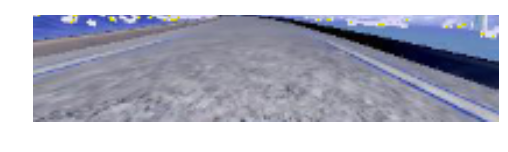

In [63]:
#Grayscale normalization. Did not end up using for final submission.
def normalize_grayscale(image_data):
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

#X_normalized = normalize_grayscale(X_train)
print('completed')

#Split validation set.
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y, test_size=0.2, random_state=0)
plt.imshow(X_train[1000])
plt.axis('off')  # clear x- and y-axes
plt.show()

In [64]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Merge, Lambda, ELU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

# For all 3 Branches: 
# Input: 66 x 200 x 3
# 1st Conv Layer Out: 33 x 100 x 28, 
# 2nd Conv Layer Out: 17 x 50 x 36
# 3rd Conv Layer Out: 9 x 25 x 48
# 4th Conv Layer Out: 5 x 13 x 64
# FC layer 1 out: 512
# FC Layer 2 Out: 100
# FC Layer 3 Out: 30
# FC Layr 4 Out: 1

def baseline_model():
# create model
    model = Sequential()
    model.add(Convolution2D(28,5, 5, subsample=(2, 2), border_mode='same', input_shape=(46,200,3)))
    model.add(ELU())   
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())   
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='same'))
    model.add(ELU())   
    model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode='same'))
    model.add(ELU())   
    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='elu'))
    model.add(Dense(1))


    # Compile model. Adam optimizer, Mean Squared Error
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, loss="mse")
    return model

print("complete")


complete


In [66]:
# Load the Model
model = baseline_model()
# Generators for training and validation
train_datagen = ImageDataGenerator(featurewise_center=True ,featurewise_std_normalization=True)
validation_datagen = ImageDataGenerator()
BATCH_SIZE = 32


model.fit_generator(train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                    samples_per_epoch=BATCH_SIZE*310, 
                    validation_data=validation_datagen.flow(X_validation,Y_validation, batch_size=BATCH_SIZE), nb_val_samples=BATCH_SIZE*62, nb_epoch=15)

#Samples per Epoch = 10000
# Validation Samples = 2000

# Save the Model
if not os.path.exists("./outputs/steering_model"):
      os.makedirs("./outputs/steering_model")

model_json_str =model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(model_json_str, outfile)
model.save_weights('model.h5')
print("model saved")

Epoch 1/15


/home/carnd/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py:331: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/carnd/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py:339: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


9920/9920 [==============================] - 23s - loss: 0.6922 - val_loss: 0.1035
Epoch 2/15
9910/9920 [============================>.] - ETA: 0s - loss: 0.0649

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


9942/9920 [==============================] - 22s - loss: 0.0648 - val_loss: 0.0348
Epoch 3/15
9920/9920 [==============================] - 22s - loss: 0.0410 - val_loss: 0.0288
Epoch 4/15
9942/9920 [==============================] - 22s - loss: 0.0370 - val_loss: 0.0381
Epoch 5/15
9920/9920 [==============================] - 22s - loss: 0.0336 - val_loss: 0.0264
Epoch 6/15
9942/9920 [==============================] - 22s - loss: 0.0297 - val_loss: 0.0263
Epoch 7/15
9920/9920 [==============================] - 22s - loss: 0.0274 - val_loss: 0.0236
Epoch 8/15
9942/9920 [==============================] - 21s - loss: 0.0254 - val_loss: 0.0193
Epoch 9/15
9920/9920 [==============================] - 22s - loss: 0.0227 - val_loss: 0.0188
Epoch 10/15
9942/9920 [==============================] - 22s - loss: 0.0220 - val_loss: 0.0172
Epoch 11/15
9920/9920 [==============================] - 21s - loss: 0.0204 - val_loss: 0.0165
Epoch 12/15
9942/9920 [==============================] - 22s - loss: 